# <center>....<u>  Fit Hub Gym Center </u>....

## IBM Applied Data Science Capstone Course by Coursera

### Final Capstone Project of the IBM Data Science Professional Certificate Specialization
#### Final Report - Week 5
**_Set up Gym Center in City of Chicago, Illinois, USA_**
1. Collect data of cities in Illinois, USA by downloading the ".csv" file from 
   https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=IL
2. Scrape the data of neighborhoods of Chicago from https://www.seechicagorealestate.com/chicago-zip-codes-by-neighborhood.php
3. Merge these two datasets to obtain the required data for Chicago. Extract zip code, neighborhood and coordinates for these neighborhoods.
4. Plot and visualize the neighborhoods on map using folium library.
5. Obtain the venue data for these neighborhoods using Foursquare API.
6. Preprocess this venue data for exploratory data analysis (EDA).
7. Find the optimal number of clusters by applying "elbow" method and KMeans Clustering algorithm.
8. Obtain the frequency of each type of place in a given neighborhood (i.e., average number of such venues in that neighborhood).
9. Compress all the information about a neighborhood in 2 features using Principal Component Analysis (PCA) and visualize the neighbourhoods in this reduced form after clustering them into the "optimal number of clusters" obtained in step 7.
10. Find out how many gyms are there in a neighborhood that belong to a given cluster. This will indicate the level of competition as well as the number of potential customers in that neighborhood.
11. Now, extract the gym venues along with the neighborhood and cluster it belongs to, and plot them on map to see where the gyms  are located.
12. Display top 5 neighborhoods (according to number of gyms) and the respective number of gyms operational in those neighborhoods for each cluster.
13. Suggest the location for setting up a new gym center suitable for a particular type of business strategy, using all the information extracted upto this point .
***
####  Import libraries

In [1]:
import pandas as pd 
import numpy as np

pd.set_option("display.max_columns", None)

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geocoder
from geopy.geocoders import Nominatim # to obtain latitude and longitude values for a given address

# for scraping data from web
import requests 
from bs4 import BeautifulSoup as bsoup


# for plotting and visualization purposes
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium              # map library

# ML algorithm to cluster the neighbourhoods 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

#### Step 1: Open the link in a browser and download the dataset manually. Then  read the dataset.

In [2]:
# Read in the post code data for Illinois, USA downloaded from the link specified at the top
df1 = pd.read_csv('us-zip-code-latitude-and-longitude.csv', delimiter=';')
df1.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,60401,Beecher,IL,41.350484,-87.624080,-6,1,"41.350484,-87.62408"
1,61761,Normal,IL,40.515485,-88.986290,-6,1,"40.515485,-88.98629"
2,60174,Saint Charles,IL,41.919808,-88.304980,-6,1,"41.919808,-88.30498"
3,60304,Oak Park,IL,41.873550,-87.788500,-6,1,"41.87355,-87.7885"
4,62706,Springfield,IL,39.798850,-89.653399,-6,1,"39.79885,-89.653399"


#### Step 2: Scrape the neighborhood data for Chicago

In [3]:
url = "https://www.seechicagorealestate.com/chicago-zip-codes-by-neighborhood.php"
req=requests.get(url)

# Parse the html with Soup
page=bsoup(req.text,"html.parser")

table=page.table

results=table.find_all('tr')
nrows=len(results)
print(nrows)

print(results[:3])

print(results[0].text.split('\n'))

199
[<tr>
<td style="text-align: left;"><span style="text-decoration: underline;"><strong>Downtown</strong></span></td>
<td style="text-align: center;"><span style="text-decoration: underline;"><strong>Zip Code</strong></span></td>
</tr>, <tr>
<td><a href="/cathedral-district-chicago-homes-condos-lofts.php" target="_blank" title="Cathedral District Chicago Zip Code">Cathedral District</a></td>
<td style="text-align: center;"><a href="/60611-chicago.php">60611</a></td>
</tr>, <tr>
<td><a href="/central-station-chicago-homes-condos-lofts.php" target="_blank" title="Central Station Zip Code in Chicago">Central Station</a></td>
<td style="text-align: center;"><a href="/60605-chicago.php">60605</a></td>
</tr>]
['', 'Downtown', 'Zip Code', '']


In [4]:
columns = ['Neighborhood', 'Zip']
c0, c1 = 1, 2

# Filling up the dataframe by extracting cells from html table
df2=pd.DataFrame({}, columns=columns)
records =[]

count = 0
for i in range(1, nrows):
    row = results[i].text.split('\n')
    
    # 1. zip codes are clustered area-wise, so there is a sub-heading  for each group. which should be removed
    # 2. A row is left blank before starting zip codes for the new area, this blank row should also be removed
    if 'Zip' in row[c1] or row[c1]=='\xa0':             
        continue
    elif len(row[c1].split(','))>1:          # if multiple zip codes, append each as separate row
        for z in row[c1].split(','):
            record = pd.Series({columns[0]: row[c0], columns[1]: z}, name=count)
            df2 = df2.append(record)
            count += 1
    else:
        record = pd.Series({columns[0]: row[c0], columns[1]: row[c1]}, name=count)
        df2 = df2.append(record)
        count += 1
df2['Zip'] = df2['Zip'].astype(int)
# Drop rows that have same entry for "Neighborhood", keeping only 1 zip for that neighborhood should be sufficient
df2 = df2.drop_duplicates(subset='Neighborhood').reset_index(drop=True)
print(df2.shape)
df2.head()

(182, 2)


,Neighborhood,Zip
0,Cathedral District,60611
1,Central Station,60605
2,Dearborn Park,60605
3,Gold Coast,60610
4,Loop,60601


#### Step 3: Merge the datasets of Step 1 and Step 2, and extract only necessary columns

In [5]:
# Merge df1 and df2 and filter out data that is not required
chicago_df = pd.merge(df1, df2, on=['Zip'], how='right').dropna()
chicago_df = chicago_df.loc[chicago_df['City'].str.contains('Chicago')]
chicago_df = chicago_df.drop(['State','City','Timezone','Daylight savings time flag','geopoint'], axis=1)
chicago_df = chicago_df.sort_values('Zip').reset_index(drop=True)
chicago_df[['Latitude','Longitude']] = chicago_df[['Latitude','Longitude']].astype(float)

# save this dataset for later use
chicago_df.to_csv('chicago_zip_coordinates_neighborhood.csv', index=False)
print(chicago_df.shape)
chicago_df.head(8)

(99, 4)


,Zip,Latitude,Longitude,Neighborhood
0,60601,41.886456,-87.62325,New East Side
1,60601,41.886456,-87.62325,Loop
2,60605,41.860019,-87.61870,Central Station
3,60605,41.860019,-87.61870,Dearborn Park
4,60605,41.860019,-87.61870,Museum Campus
5,60605,41.860019,-87.61870,Printers Row
6,60605,41.860019,-87.61870,South Loop
7,60606,41.882582,-87.63760,Near West Side


#### Step 4: Plot the neighborhoods

In [6]:
# create map of Chicago using Folium library
address = 'Chicago, Illinois'
geolocator = Nominatim(user_agent="tl-chicago-neigh")
location = geolocator.geocode(address)
chicago_latitude, chicago_longitude = location.latitude, location.longitude
map_chicago = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# add markers to map
for lat, long, neighbor in zip(chicago_df['Latitude'], chicago_df['Longitude'], chicago_df['Neighborhood']):
    label = neighbor
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_chicago)  
    
map_chicago

#### Step 5: Obtain venue data for each of these neighborhoods using Foursquare API

In [7]:
# Foursquare API ID and Key
CLIENT_ID = '1XFAKAXQ3VPCE0XGOYQUPLLMVNN4MAD22YAI2AX05TU22CFJ' # ID
CLIENT_SECRET = 'KRM2XCFTG12NFN2JAP4IQQWXTCBBCGSL2AQ4IXBWTKXDRRMY' # Secret
VERSION = '20180605' # version

In [8]:
radius = 5000
LIMIT = 100

venues = []

for lat, long, zip_code, neighbor in zip(chicago_df['Latitude'], chicago_df['Longitude'], chicago_df['Zip'], chicago_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            zip_code,
            neighbor,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))
        
places_df = pd.DataFrame(venues)
places_df.columns = ['Zip', 'Neighborhood', 'N_lat', 'N_long', 'Place', 'Place_lat', 'Place_long', 'Category']

# save this dataset for later use
places_df.to_csv('venues_in_chicago.csv', index=False)

print(places_df.shape)
places_df.head()

(9900, 8)


,Zip,Neighborhood,N_lat,N_long,Place,Place_lat,Place_long,Category
0,60601,New East Side,41.886456,-87.62325,"LondonHouse Chicago, Curio Collection by Hilton",41.887832,-87.625426,Hotel
1,60601,New East Side,41.886456,-87.62325,Chicago Architecture Center,41.887720,-87.623650,Tour Provider
2,60601,New East Side,41.886456,-87.62325,sweetgreen,41.884964,-87.624728,Salad Place
3,60601,New East Side,41.886456,-87.62325,Chicago Riverwalk,41.887280,-87.627217,Waterfront
4,60601,New East Side,41.886456,-87.62325,Roti Modern Mediterranean,41.886048,-87.624948,Mediterranean Restaurant


In [9]:
places_df.groupby('Neighborhood').count()

,Zip,N_lat,N_long,Place,Place_lat,Place_long,Category
Neighborhood,,,,,,,
Albany Park,100,100,100,100,100,100,100
Alta Vista Terrace,100,100,100,100,100,100,100
Andersonville,100,100,100,100,100,100,100
Avondale,100,100,100,100,100,100,100
Back of the Yards,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
West Town,100,100,100,100,100,100,100
Wicker Park,100,100,100,100,100,100,100
Woodlawn,100,100,100,100,100,100,100


Total 9900 venues were retrieved, 100 Venues for each zip code.

In [10]:
print('No of categories of places: ', places_df['Category'].nunique())

print('No of entries that contain "Gym" of "Fitness" in the name of place: ',(places_df['Category'].str.contains('Gym') | places_df['Category'].str.contains('Fitness') ).sum())

print('Different types of categories that contain "Gym": \n', places_df.loc[places_df['Category'].str.contains('Gym'), 'Category'].unique())

No of categories of places:  248
No of entries that contain "Gym" of "Fitness" in the name of place:  310
Different types of categories that contain "Gym": 
 ['Gym / Fitness Center' 'Gym' 'Climbing Gym' 'Boxing Gym' 'Gymnastics Gym']


#### Step 6: Preprocessing

In [11]:
# Combine similar categories into one single broad category

# dictionary that maps a broad category to the list of keywords that belong to a particular broad category
broad_categories = {'Food':['Food','Pizza','Burger','Burrito','Noodle','Sandwich','Pie','Salad','Sushi','Steak',
                          'Taco','Smoothie','Ice Cream','Chocolate','Candy','Bakery','Bagel','BBQ','Cupcake',
                          'Restaurant','Breakfast','Diner'],
                    'Gym':['Gym','Fitness'],
                    'Beverage':['Wine','Beer','Coffee','Tea','Whiskey','Juice','Liquor','Brewery'],
                    'Health':['Health','Field','Yoga','Supplement','Sport','Soccer','Hockey','Golf','Athletic'],
                    'Salon':['Salon','Massage','Beauty','Cosmetics','Spa'],
                    'Art':['Art','Gallery','Museum','Planetarium','Music','Hobby'],
                    'Theater':['Theater','Movie','Hall','Concert','Cultur'],
                    'Entertainment':['Pub','Bar','Club'],
                    'Shop':['Shop','Store','Market','Joint'] }

for broad_category in broad_categories.keys():
    belonging_categories = []                           # list of "actual categories" that belong to this broad category
    #print(broad_category)
    for keyword in broad_categories[broad_category]:
        categories_having_keyword = places_df.loc[places_df['Category'].str.contains(keyword), 'Category'].unique().tolist()
        belonging_categories += categories_having_keyword
            
    places_df['Category'] = places_df['Category'].replace(belonging_categories, broad_category)

# Replace unspecified categories by "Others" category
others = [c for c in places_df['Category'].unique() if c not in broad_categories.keys()]
places_df['Category'] = places_df['Category'].replace(others, 'Others')

# one hot encoding
chicago_onehot = pd.get_dummies(places_df[['Category']], prefix="", prefix_sep="")

# add zip and neighborhood column back to dataframe
chicago_onehot['Zip'] = places_df['Zip'] 
chicago_onehot['Neighborhood'] = places_df['Neighborhood'] 

# move zip and neighborhood column to the first column
columns_in_order = list(chicago_onehot.columns[-2:]) + list(chicago_onehot.columns[:-2])
chicago_onehot = chicago_onehot[columns_in_order]

print(chicago_onehot.shape)
chicago_onehot.head()

(9900, 12)


,Zip,Neighborhood,Art,Beverage,Entertainment,Food,Gym,Health,Others,Salon,Shop,Theater
0,60601,New East Side,0,0,0,0,0,0,1,0,0,0
1,60601,New East Side,0,0,0,0,0,0,1,0,0,0
2,60601,New East Side,0,0,0,1,0,0,0,0,0,0
3,60601,New East Side,0,0,0,0,0,0,1,0,0,0
4,60601,New East Side,0,0,0,1,0,0,0,0,0,0


In [12]:
# Total number of occurences for each broad category
chicago_onehot[[col for col in chicago_onehot.columns if col not in ['Zip','Neighborhood']]].sum(axis=0)

Art               236
Beverage         1141
Entertainment     420
Food             3876
Gym               310
Health            194
Others           2034
Salon             194
Shop             1288
Theater           207
dtype: int64

#### Step 7: Apply elbow method to find optimal number of clusters

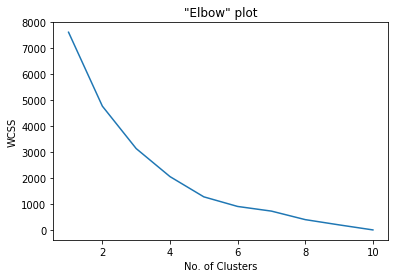

In [13]:
max_clusters=10    
wcss = []
for i in range(1,max_clusters+1,1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(chicago_onehot.drop(['Zip','Neighborhood'], axis=1).values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,max_clusters+1), wcss)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.title('\"Elbow\" plot')
plt.show()

The elbow plot shows that the optimal number of clusters is 5. Let's plot the Prinicipal components for each neighborhood after clustering the average venue frequencies into 5 groups.

#### Step 8, Step 9: Obtain the frequency of each type of place in a neighborhood; visualize the neighborhoods after applying PCA

Variance is satisfactorily explained by the extracted components (~82%) 


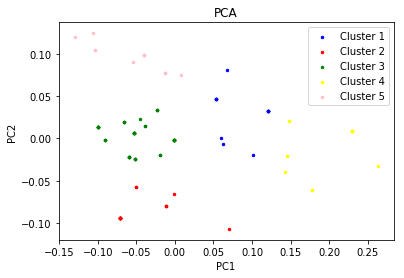

In [21]:
# obtain how frequent each venue category is in a neighborhood
chicago_venues_freq = chicago_onehot.groupby(['Zip', 'Neighborhood']).mean().reset_index()

# extract as much information as possible in 2 dimensions to make it easy to visualize
pca = PCA(n_components=2)           
X = pca.fit_transform(chicago_venues_freq.drop(['Zip','Neighborhood'], axis=1).copy())
explained_variance = pca.explained_variance_ratio_

if explained_variance.sum()>0.70:
    print('Variance is satisfactorily explained by the extracted components (~{}%) '.format('%.0f'%(100*explained_variance.sum())))
else:
    print('Variance is NOT satisfactorily explained by the extracted components (~{}%) '.format('%.0f'%(100*explained_variance.sum())))

plot_df = pd.DataFrame(X, columns=['PC1','PC2'])
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=0).fit(X)
chicago_venues_freq['Cluster'] = plot_df['label'] = kmeans.labels_

plt.scatter(plot_df.loc[plot_df['label']==0, 'PC1'], plot_df.loc[plot_df['label']==0, 'PC2'], s=6, color='blue', label='Cluster 1')
plt.scatter(plot_df.loc[plot_df['label']==1, 'PC1'], plot_df.loc[plot_df['label']==1, 'PC2'], s=6, color='red', label='Cluster 2')
plt.scatter(plot_df.loc[plot_df['label']==2, 'PC1'], plot_df.loc[plot_df['label']==2, 'PC2'], s=6, color='green', label='Cluster 3')
plt.scatter(plot_df.loc[plot_df['label']==3, 'PC1'], plot_df.loc[plot_df['label']==3, 'PC2'], s=6, color='yellow', label='Cluster 4')
plt.scatter(plot_df.loc[plot_df['label']==4, 'PC1'], plot_df.loc[plot_df['label']==4, 'PC2'], s=6, color='pink', label='Cluster 5')
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [15]:
chicago_venues_freq.head()

,Zip,Neighborhood,Art,Beverage,Entertainment,Food,Gym,Health,Others,Salon,Shop,Theater,Cluster
0,60601,Loop,0.04,0.06,0.01,0.31,0.04,0.01,0.31,0.02,0.13,0.07,3
1,60601,New East Side,0.04,0.06,0.01,0.31,0.04,0.01,0.31,0.02,0.13,0.07,3
2,60605,Central Station,0.06,0.06,0.04,0.26,0.01,0.02,0.38,0.00,0.12,0.05,3
3,60605,Dearborn Park,0.06,0.06,0.04,0.26,0.01,0.02,0.38,0.00,0.12,0.05,3
4,60605,Museum Campus,0.06,0.06,0.04,0.26,0.01,0.02,0.38,0.00,0.12,0.05,3


#### Step 10: Analyze competition level, number of potential customers in each cluster

In [16]:
for i in sorted(chicago_venues_freq['Cluster'].unique()):
    n_neighborhoods = chicago_venues_freq.loc[chicago_venues_freq['Cluster']==i].shape[0]
    min_gyms = chicago_venues_freq.loc[chicago_venues_freq['Cluster']==i, 'Gym'].min()*100
    mean_gyms = chicago_venues_freq.loc[chicago_venues_freq['Cluster']==i, 'Gym'].mean()*100
    median_gyms = chicago_venues_freq.loc[chicago_venues_freq['Cluster']==i, 'Gym'].median()*100
    max_gyms = chicago_venues_freq.loc[chicago_venues_freq['Cluster']==i, 'Gym'].max()*100
    
    print('Cluster: {}  |  # of neighborhoods: {}   |   # of Gyms per neighborhood=>   min: {}    avg: {}    median: {}   max: {}'.format(int(i), int(n_neighborhoods), int(min_gyms), int(mean_gyms), int(median_gyms), int(max_gyms)))

Cluster: 0  |  # of neighborhoods: 13   |   # of Gyms per neighborhood=>   min: 1    avg: 2    median: 2   max: 5
Cluster: 1  |  # of neighborhoods: 17   |   # of Gyms per neighborhood=>   min: 2    avg: 5    median: 6   max: 6
Cluster: 2  |  # of neighborhoods: 44   |   # of Gyms per neighborhood=>   min: 1    avg: 3    median: 3   max: 6
Cluster: 3  |  # of neighborhoods: 13   |   # of Gyms per neighborhood=>   min: 1    avg: 2    median: 2   max: 4
Cluster: 4  |  # of neighborhoods: 12   |   # of Gyms per neighborhood=>   min: 1    avg: 2    median: 2   max: 4


## _Cluster 1 has highest competition!_

The number of Gyms per neighborhood in Cluster 1 is highest (more than 50% of neighborhoods have 6+ Gyms). Similarly, Cluster 2 also shows considerable competition (more than 50% of neighborhoods have 3+ Gyms).

#### Step 11: Extract gym venues and their respective neighborhoods and clusters. Plot them on map.

In [17]:
chicago_info = pd.merge(chicago_venues_freq[['Zip','Neighborhood','Cluster']], places_df, on=['Zip','Neighborhood'], how='inner').sort_values(['Cluster','Zip'])

# Extract only rows that have Gym venues
chicago_info = chicago_info.loc[chicago_info['Category']=='Gym'].reset_index(drop=True)
print(chicago_info.shape)
chicago_info.head()

(310, 9)


,Zip,Neighborhood,Cluster,N_lat,N_long,Place,Place_lat,Place_long,Category
0,60606,Near West Side,0,41.882582,-87.6376,Fitness Formula Club (FFC),41.881485,-87.641517,Gym
1,60606,Near West Side,0,41.882582,-87.6376,East Bank Club,41.889694,-87.638922,Gym
2,60606,Near West Side,0,41.882582,-87.6376,Studio Three,41.893999,-87.631373,Gym
3,60606,Near West Side,0,41.882582,-87.6376,Brooklyn Boulders Chicago,41.880311,-87.652083,Gym
4,60606,Near West Side,0,41.882582,-87.6376,Barry's Bootcamp,41.893903,-87.628699,Gym


In [18]:
# Note: Gyms that have same latitude and longitude get shadowed in the map, so only 1 Gym gets 
#       displayed on the map for each unique set of coordinates.

clusters = chicago_info['Cluster'].unique()

# create map
map_clusters = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(clusters))
ys = [i+x+(i*x)**2 for i in range(len(clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = {c:colors.rgb2hex(colors_array[i]) for i,c in enumerate(clusters)}

# add markers to the map
markers_colors = []
count =0
for place, p_lat, p_long, neighbor, cluster in zip(chicago_info['Place'], chicago_info['Place_lat'], chicago_info['Place_long'], chicago_info['Neighborhood'], chicago_info['Cluster']):
    count += 1
    label = folium.Popup(place + ', Neigbborhood: ' + str(neighbor) + ',  Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [p_lat, p_long],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Step 12: Top neighborhoods in each cluster

In [19]:
# Print Top k places for each cluster
k=5
for i in chicago_info['Cluster'].unique():
    print('\n-------------------- Cluster {} --------------------'.format(i))
    top_places = chicago_info.loc[chicago_info['Cluster']==i, 'Neighborhood'].value_counts().index[:k].tolist()
    no_of_gyms = chicago_info.loc[chicago_info['Cluster']==i, 'Neighborhood'].value_counts()[:k].tolist()
    for p in range(k):
        print('{}.  {}    ({} gyms) '.format(p+1, top_places[p], no_of_gyms[p]))
    


-------------------- Cluster 0 --------------------
1.  Near West Side    (5 gyms) 
2.  River East    (3 gyms) 
3.  Cathedral District    (3 gyms) 
4.  River North    (3 gyms) 
5.  Streeterville    (3 gyms) 

-------------------- Cluster 1 --------------------
1.  Alta Vista Terrace    (6 gyms) 
2.  Ravenswood     (6 gyms) 
3.  North Halsted    (6 gyms) 
4.  Wrigleyville    (6 gyms) 
5.  East Ravenswood    (6 gyms) 

-------------------- Cluster 2 --------------------
1.  North Park    (6 gyms) 
2.  Budlong Woods    (6 gyms) 
3.  Ravenswood Manor     (6 gyms) 
4.  Lincoln Square    (6 gyms) 
5.  Albany Park    (6 gyms) 

-------------------- Cluster 3 --------------------
1.  Loop    (4 gyms) 
2.  New East Side    (4 gyms) 
3.  Oakland    (3 gyms) 
4.  Bronzeville    (3 gyms) 
5.  Kenwood    (2 gyms) 

-------------------- Cluster 4 --------------------
1.  Edison Park    (4 gyms) 
2.  Old Norwood Park     (4 gyms) 
3.  Norwood Park     (4 gyms) 
4.  Mount Greenwood    (2 gyms) 
5.  S

#### Step 13:
### <center>....<u>Results and Recommendations</u>....
***

### 1. Aggressive strategy: 

For clients who can boast of their highest quality gym centres, or clients who are capable enough (big "Fitness Chains") and favour aggressive strategy of dominating the competition should set up their gym centre(s) closer to the places (listed above) that are grouped under Cluster 1 or Cluster 2.   

### 2. Medium-competition, medium profit strategy:

For clients who favour the "just right" competition, or are new and looking to establish their brand name in the market without taking extreme risks, and can cater to medium to small crowds qualitatively, it is recommended to set up new gym centers closer to the existing gym centres in the neighborhoods that belong to Cluster 0 or Cluster 3. 

### 3. Minimum competition, Satisfactory profits:

For risk averse clients and business with comparatively small assets, who can not cater to large number of customers while maintaining a good quality of service, should set up their gym centres in the neighborhoods that belong to Cluster 4, preferably with a sufficient distance from the existing gym centres in those neighborhoods. This type of neighborhood is also suitable for clients who just want to do a market testing through a small project, or for clients who want to establish gym centre as a side business and can not devote much time for the growth of business.